## load baseline results

In [37]:
import pickle
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import tabulate
import numpy as np

In [38]:
date_time_id = '20250127_A_2000_episodes'

file_path = '../results/custom_execution_baseline_results_{}.pkl'.format(date_time_id)
with open(file_path, 'rb') as fin:        
    baseline_results_dict = pickle.load(fin)
    print(f"***** baseline results LOADED from {file_path} *****")

***** baseline results LOADED from ../results/custom_execution_baseline_results_20250127_A_2000_episodes.pkl *****


In [39]:
baseline_stats = []
baseline_stats.append(np.mean(baseline_results_dict['rewards'])) # mean reward
baseline_stats.append(np.std(baseline_results_dict['rewards'])) # std reward
baseline_stats.append(np.median(baseline_results_dict['rewards'])) # median reward
baseline_stats.append(np.mean(baseline_results_dict['terminal_inventories'])) # mean terminal inventory
baseline_stats.append(np.std(baseline_results_dict['terminal_inventories'])) # std terminal inventory
baseline_stats.append(int(np.min(baseline_results_dict['terminal_inventories']))) # min terminal inventory
baseline_stats.append(int(np.max(baseline_results_dict['terminal_inventories']))) # max terminal inventory

cols = [
    'Mean\nreward', 'Std\nreward', 'Median\nreward','Mean terminal\ninventory', 
    'Std terminal\ninventory', 'Min terminal\ninventory', 'Max terminal\ninventory' 
]    
print(tabulate.tabulate([baseline_stats], headers=cols, floatfmt='.5f'))

    Mean       Std    Median    Mean terminal    Std terminal    Min terminal    Max terminal
  reward    reward    reward        inventory       inventory       inventory       inventory
--------  --------  --------  ---------------  --------------  --------------  --------------
-0.08440   0.07359  -0.06188         -0.21650        13.09514             -24              25


## load test results

In [ ]:
date_time_id = '20250127_A_@3000_for_2000'

file_path = '../results/custom_execution_test_results_{}.pkl'.format(date_time_id)
with open(file_path, 'rb') as fin:        
    test_results_dict, _ = pickle.load(fin)
    print(f"***** test results LOADED from {file_path} *****")

## investigate rewards

Judging from histogram and boxplot plots, the distribution of the negative episode rewards may be estimated by a three parameter log-normal distribution with parameters shape, loc, scale. We say $X\sim \text{log-normal}(\mu, \sigma^2, \delta)$, with the parameters $\mu\in\mathbb{R}, \sigma > 0$, and location parameter $\delta\in\mathbb{R}$, if $ln(X-\delta) \sim \mathcal{N}(\mu, \sigma^2)$. The transformed random variable $Y:= \ln(X - \delta)/\sigma$ has standard normal distribution. Applying this transformation to the data set of negative episode reward with the fitted parameters we can test for normality.

**Note:** The `scipy`function `stats.lognorm.fit` fits a three parameter log-normal distribution to a given data set, but returns the values `(shape, loc, scale)` with `shape` $=\sigma$, `loc` $=\delta$, and `scale` $=\exp(\mu)$.

In [ ]:
# histogram and boxplot
rewards = np.array(baseline_results_dict['rewards'])
fig, axs = plt.subplots(1, 2, figsize=(9,4))
axs[0].hist(rewards, bins=100, density=False)
axs[1].boxplot(rewards)
plt.show()

### Fit 3 parameter log-normal

We fit a three parameter log-normal distrbution to the data $\{R_n\}_{n=1,\dots,3000}$ with $R_n$ the total reward obtained in episode $n$. With the obtained values `(shape, loc, scale)` we transform the data to normal.

With location parameter estimated.

0.780125293821907 -0.0016901585288279608 0.063883025477181


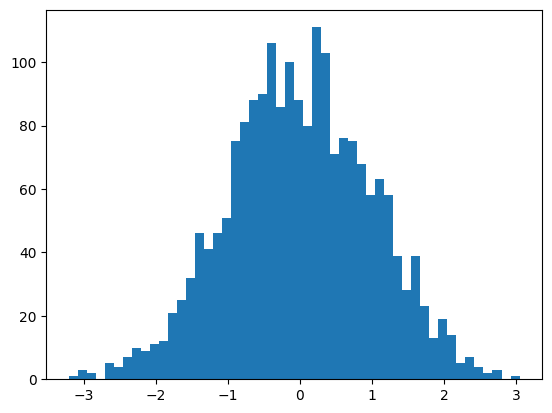

scipy Anderson: AndersonResult(statistic=0.4499528021528931, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
scipy Shapiro: ShapiroResult(statistic=0.9989356398582458, pvalue=0.2767109274864197)
scipy normaltest: NormaltestResult(statistic=3.095720835653119, pvalue=0.21270258197020553)
scipy Jarque-Bera: Jarque_beraResult(statistic=2.8635456582064873, pvalue=0.23888504426436197)
stats Anderson: (0.4499528021528931, 0.2758294857210485)
stats Jarque-Bera: (2.8635456582064873, 0.23888504426436194, -0.03683550633788142, 2.8298967084686324)


In [40]:
rewards = np.array(np.array(baseline_results_dict['rewards']))
shape, loc, scale  = stats.lognorm.fit(-rewards, method='MLE')
lognorm_params = (shape, loc, scale)
print(shape, loc, scale)
#plt.boxplot(np.log(-np.array(baseline_results_dict[0]['rewards'])))
#plt.show()

# some tests need standardization
stdized_rewards = (np.log(-rewards - loc) - np.log(scale)) / shape
plt.hist(stdized_rewards, bins=50, density=False)
plt.show()

print('scipy Anderson:', stats.anderson(stdized_rewards))
print('scipy Shapiro:', stats.shapiro(stdized_rewards,))
print('scipy normaltest:', stats.normaltest(stdized_rewards))
print('scipy Jarque-Bera:', stats.jarque_bera(stdized_rewards))
print('stats Anderson:', sm.stats.diagnostic.normal_ad(stdized_rewards))
print('stats Jarque-Bera:', sm.stats.stattools.jarque_bera(stdized_rewards))
# jarque_bera only works for n > 2000

In [ ]:
# compare histograms and boxplots for data and fitted lognormal distribution
x = stats.lognorm.rvs(shape, loc=loc, scale=scale, size=len(rewards))
plt.hist(np.array(baseline_results_dict['rewards']), bins=100, density=True, label='rewards')
plt.hist(-x, bins=100, density=True, label='lognorm', alpha=0.5)
plt.legend()
plt.show()
plt.boxplot([-x, baseline_results_dict['rewards']])
plt.show()

# Q-Q plots
fig, axs = plt.subplots(1, 2, figsize=(9,4))
stats.probplot(stdized_rewards, dist='norm', plot=axs[0])
stats.probplot(-rewards, dist=stats.lognorm, sparams=lognorm_params, plot=axs[1])
plt.show()

### Gof-tests with parametric bootstrapping
Calculate critical values for some tests using parametric bootstrapping.

In [41]:
rewards = np.array(baseline_results_dict['rewards'])
n = len(rewards)

# fit lognormal distribution
shape, loc, scale = stats.lognorm.fit(-rewards, loc=0.0)
stdized_rewards = (np.log(-rewards - loc) - np.log(scale)) / shape

# calculate test statistics for negative rewards
print(stats.anderson(stdized_rewards))
print(stats.shapiro(stdized_rewards))
print(stats.kstest(-rewards, stats.lognorm.cdf, args=(shape, loc, scale)))
stat_anderson = stats.anderson(stdized_rewards)
stat_shapiro = stats.shapiro(stdized_rewards)
stat_ks = stats.kstest(-rewards, stats.lognorm.cdf, args=(shape, loc, scale))

# generate bootstrap samples
bootstrap_samples = stats.lognorm.rvs(shape, loc=loc, scale=scale, size=(1000, n))
bootstrap_AD = []
bootstrap_Shapiro = []
bootstrap_KS = []
# calculate test statistics for each bootstrap sample
for sample in bootstrap_samples:
    s_shape, s_loc, s_scale = stats.lognorm.fit(sample, loc=0.0)
    stdzd_sample = (np.log(sample - s_loc) - np.log(s_scale)) / s_shape
    bootstrap_AD.append(stats.anderson(stdzd_sample, dist='norm')[0])
    bootstrap_Shapiro.append(stats.shapiro(stdzd_sample)[0])
    bootstrap_KS.append(stats.kstest(sample, stats.lognorm.cdf, args=(s_shape, s_loc, s_scale))[0])

# calculate critical values and p-values
tst_lvl = 90.0
print('\nbootstrap results:')
print(f'AD {tst_lvl}%:', np.percentile(np.array(bootstrap_AD), tst_lvl))
print('AD p-value:', np.mean(np.array(bootstrap_AD) > stat_anderson[0]))
print(f'Shapiro {tst_lvl}%:', np.percentile(np.array(bootstrap_Shapiro), tst_lvl))
print('Shapiro p-value:', np.mean(np.array(bootstrap_Shapiro) < stat_shapiro[0]))
print(f'KS {tst_lvl}%:', np.percentile(np.array(bootstrap_KS), tst_lvl)) 
print('KS p-value:', np.mean(np.array(bootstrap_KS) > stat_ks[0]))

scipy Anderson: AndersonResult(statistic=0.4503475614783383, critical_values=array([0.575, 0.655, 0.785, 0.916, 1.09 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
scipy Shapiro: ShapiroResult(statistic=0.9989323616027832, pvalue=0.27412962913513184)
scipy KS: KstestResult(statistic=0.014498610118329258, pvalue=0.7887881553076839)
AD 90.0%: 0.5713252508710411
AD p-value: 0.215
Shapiro 90.0%: 0.9995489895343781
Shapiro p-value: 0.136
KS 90.0%: 0.017826444670116626
KS p-value: 0.336


## confidence intervals

### based on large sample theory

In [ ]:
rewards = np.array(baseline_results_dict['rewards'])
n = len(rewards)
z = stats.norm.ppf(0.975, loc=0, scale=1)
mean = np.mean(rewards)
std = np.std(rewards)
sem = stats.sem(rewards, ddof=0)
print(sem == std/np.sqrt(len(rewards)))

CI_large_sample = stats.norm.interval(0.95, loc=mean, scale=sem)
print(CI_large_sample)
# same as
#print((mean - z * std / np.sqrt(n), mean + z * std / np.sqrt(n)))

### based on log-normal fit
assuming non-zero loc from lognormal fit

In [ ]:
rewards = np.array(baseline_results_dict['rewards'])
shape, loc, scale = stats.lognorm.fit(-rewards, loc=0.0)
print(shape, loc, scale)

t = stats.t.ppf(0.975, df=1, loc=0, scale=1)
mean_log_neg_r = np.log(scale) # mean of (-R - loc), i.e. lognormal with location 0
std_estimate = np.sqrt(shape ** 2 / n + shape ** 4 / (2*(n - 1)))

CI_neg_r_wo_loc = (np.exp(mean_log_neg_r + shape ** 2 / 2 - t * std_estimate), 
                   np.exp(mean_log_neg_r + shape ** 2 / 2 + t * std_estimate))
CI_neg_r_w_loc = (CI_neg_r_wo_loc[0] + loc, CI_neg_r_wo_loc[1] + loc)
CI_r_w_loc = (-CI_neg_r_w_loc[1], -CI_neg_r_w_loc[0])
print(CI_r_w_loc)

### based on Olssen paper
assuming loc=0 for log normal fit

In [ ]:
rewards = np.array(baseline_results_dict['rewards'])
n = len(rewards)
t = stats.t.ppf(0.975, df=2000, loc=0, scale=1)

mean_log_neg_r = np.log(-rewards).mean()
std_log_neg_r = np.log(-rewards).std()
std_estimate = np.sqrt(std_log_neg_r ** 2 / n + std_log_neg_r ** 4 / (2*(n - 1)))

CI_log_r = (np.exp(mean_log_neg_r + std_log_neg_r ** 2 / 2 - t * std_estimate), 
            np.exp(mean_log_neg_r + std_log_neg_r ** 2 / 2 + t * std_estimate))
CI_log_r = (-CI_log_r[1], -CI_log_r[0])
print(CI_log_r)

In [ ]:
file_path = '../results/lognormaldata.pkl'
with open(file_path, 'wb') as fout:  
    pickle.dump(-np.array(baseline_results_dict['rewards']), fout)

### comparison of results:

**Intervals**
- for first 2000 episode sample

        large sample CI =   (-0.087628, -0.081177)  -0.006451  
        lognorm fit CI =    (-0.088366, -0.081597)  -0.006769
        Olssen CI =         (-0.089045, -0.082041)  -0.007004

- for second 2000 episode sample

        large sample CI =   (-0.090476, -0.083226)  -0.007250 
        lognorm fit CI =    (-0.090564, -0.083312)  -0.007252
        Olssen CI =         (-0.091417, -0.083886)  -0.007531

- for third 2000 episode sample

        large sample CI =   (-0.092140, -0.085115)  -0.007025
        lognorm fit CI =    (-0.092574, -0.085305)  -0.007269
        Olssen CI =         (-0.093780, -0.086114)  -0.007666

**Fit**
- with first 2000 episodes sample
log normal fit: 0.7800772923280497 -0.001695245289439037 0.06388987175054339

- with second 2000 episodes sample
log normal fit:0.8107304974736751 -0.0015869911420958009 0.06367581684058965

- for third 2000 episode sample
0.7921070674008809 -0.0024017647583191902 0.06669789989475025


## mid price changes
Investige mean and maximal mid price changes to estimate rewards distribution

In [ ]:
# mid price changes in test results

total_episodes = 20000
total_steps = total_episodes * 180

mp_changes = {}
mp_changes_means = {}
mp_changes_maxs = {}

for run, test_run in test_results_dict.items():
    mp_changes[run] = [
        abs(np.array(mp[1:]) - np.array(mp[:-1]))
        for mp in test_run['mid_prices']
    ]
    mp_changes_means[run] = [mp_changes.mean() for mp_changes in mp_changes[run]]
    mp_changes_maxs[run] = [mp_changes.max() for mp_changes in mp_changes[run]]

mo_means = {key: np.mean(means) for key, means in mp_changes_means.items()}
mo_maxs = {key: np.mean(maxs) for key, maxs in mp_changes_maxs.items()}
mo_means['momo_means'] = np.mean(list(mo_means.values()))
mo_maxs['momo_maxs'] = np.mean(list(mo_maxs.values()))
print(tabulate.tabulate(mo_means.items(), headers=['Run', 'Mean of mean mid-price changes']))
print(tabulate.tabulate(mo_maxs.items(), headers=['Run', 'Mean of max mid-price changes']))

"""
for means, maxs in zip(mp_changes_means.values(), mp_changes_maxs.values()):
    plt.hist(means, bins=100)
    plt.show()
    plt.hist(maxs, bins=100)
    plt.show()
"""    

assumed_max_change = 34 #mo_maxs['momo_maxs']
assumed_min_change = mo_means['momo_means']
max_episode_reward = (assumed_max_change/100 * 180 + 0.7) * (25/1000) ** 2 \
    - sum([ ((700 - i * 50) / 1000) **  2 for i in range(15)]) * assumed_min_change/100
print('maximal episode reward:', max_episode_reward)
print(
    f'pct of total mid price changes larger {assumed_max_change}:', 
    sum([sum(np.array(episode)>assumed_max_change) for run in mp_changes.values() for episode in run]) / total_steps
)
print(
    f'pct of max mid price changes larger {assumed_max_change}:', 
    sum([sum(np.array(maxs) > assumed_max_change) for maxs in mp_changes_maxs.values()]) / total_episodes
)


In [ ]:
shape, loc, scale = 0.8, -0.3, 0.1
samples = stats.lognorm.rvs(shape, loc=loc, scale=scale, size=2000)
#plt.hist(samples, bins=100)
#plt.show()
stats.probplot(samples, dist='lognorm', sparams=(shape, loc, scale), plot=plt)
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(9,4))
#stats.probplot((np.log(samples - loc) -  np.log(shape))/scale, dist='norm', plot=axs[0])
stats.probplot((np.log(samples - loc) -  np.log(scale))/shape, dist='norm', plot=axs[1])
plt.show()